In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display

In [2]:
nPerClass = 1000
imgSize = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

widths = [1.8,2.4]

images = torch.zeros(2*nPerClass,1,imgSize,imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):

  ro = 2*np.random.randn(2)
  G = np.exp(-( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) )

  G = G + np.random.randn(imgSize,imgSize) / 5

  images[i,:,:,:] = torch.Tensor(G).view(1, imgSize,imgSize)
  labels[i] = i%2

labels = labels[:,None]


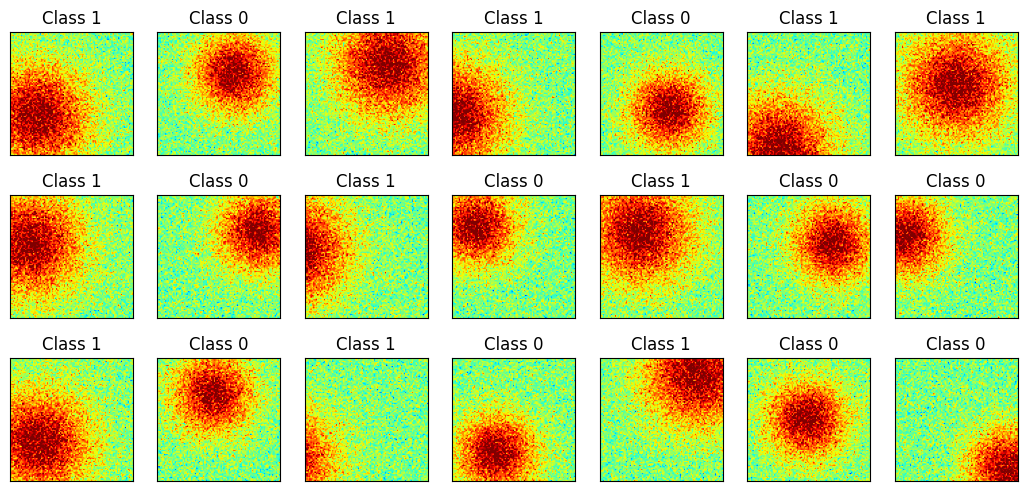

In [3]:
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
  anypic = np.random.randint(2*nPerClass)
  G = np.squeeze( images[anypic,:,:])
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_title('Class %s'%int(labels[anypic].item()))
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [4]:
train_data,test_data,train_labels,test_labels = train_test_split(images, labels, test_size=.1)

train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)

batchsize = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [6]:
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([1800, 1, 91, 91])
torch.Size([1800, 1])


In [11]:
def createNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()

      self.enc = nn.Sequential(
          nn.Conv2d(1,6,3,padding=1),
          nn.ReLU(),
          nn.AvgPool2d(2,2),
          nn.Conv2d(6,4,4,padding=1),
          nn.ReLU(),
          nn.AvgPool2d(2,2),
          nn.Flatten(),
          nn.Linear(22*22*4,50),
          nn.Linear(50,1),
          )

    def forward(self,x):
        return self.enc(x)


  net = gausnet()

  lossfun = nn.BCEWithLogitsLoss()

  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [12]:
net,lossfun,optimizer = createNet()

X,y = next(iter(train_loader))
yHat = net(X)

print(yHat.shape)

torch.Size([32, 1])


In [14]:
summary(net,(1,imgSize,imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         AvgPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 44, 44]             388
              ReLU-5            [-1, 4, 44, 44]               0
         AvgPool2d-6            [-1, 4, 22, 22]               0
           Flatten-7                 [-1, 1936]               0
            Linear-8                   [-1, 50]          96,850
            Linear-9                    [-1, 1]              51
Total params: 97,349
Trainable params: 97,349
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.00
Params size (MB): 0.37
Estimated Total Size (MB): 1.40
---------------------------------------------

In [27]:
num_epochs = 60

def trainModel():

  net,lossfun,optimizer = createNet()


  trainacc =[]
  testacc=[]
  trainloss = []
  testloss = []

  for epochi in range(num_epochs):

    batchacc = []
    batchloss = []

    for data,labels in train_loader:

      yHat = net(data)
      loss = lossfun(yHat,labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      batchloss.append(loss.item())

      batchacc.append( torch.mean( ( (yHat >.5) == labels).float()).item())

    trainacc.append(100* np.mean(batchacc))
    trainloss.append(np.mean(batchloss))


    for data,labels in test_loader:

      preddigits = net(data)

      loss = lossfun(preddigits,labels)

    testacc.append(100*torch.mean(((preddigits >0)==labels).float()).item())
    testloss.append(loss.item())

  return net,trainacc,testacc,trainloss,testloss


In [28]:
net,trainacc,testacc,trainloss,testloss = trainModel()

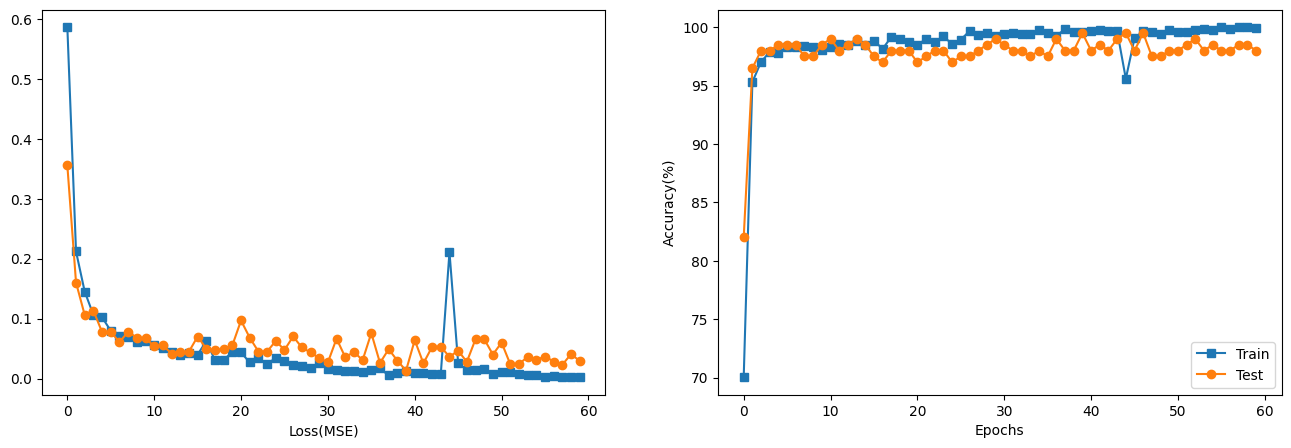

In [29]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainloss,'s-',label='Train')
ax[0].plot(testloss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_xlabel('Loss(MSE)')


ax[1].plot(trainacc,'s-',label='Train')
ax[1].plot(testacc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy(%)')

plt.legend()

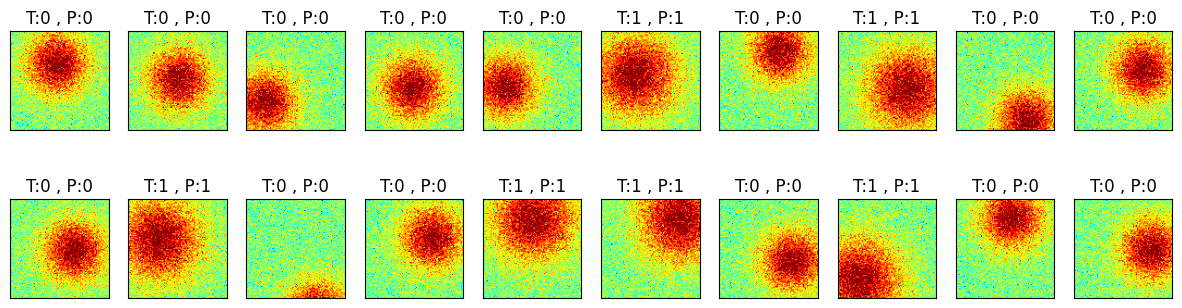

In [30]:
X,y = next(iter(test_loader))
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(15,4))

for i,ax in enumerate(axs.flatten()):
  G = torch.squeeze(X[i,0,:,:]).detach()
  t = ( int(y[i].item()), int(yHat[i].item()>.5 ) )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_title('T:%s , P:%s'%t)
  ax.set_xticks([])
  ax.set_yticks([])

In [31]:
print(net)

layer1W = net.enc[0].weight
layer3W = net.enc[3].weight

print(' ')
print(layer1W.shape)
print(layer3W.shape)

gausnet(
  (enc): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 4, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1936, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)
 
torch.Size([6, 1, 3, 3])
torch.Size([4, 6, 4, 4])


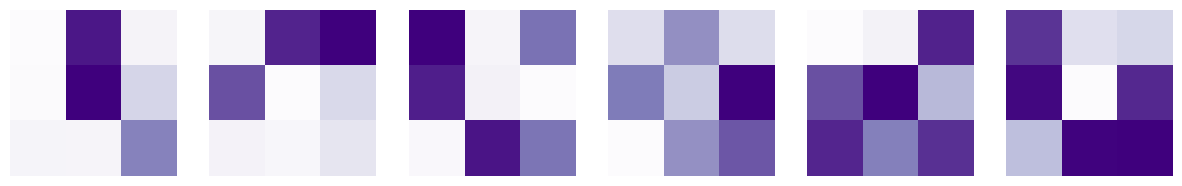

In [32]:
fig,axs = plt.subplots(1,6,figsize=(15,3))

for i,ax in enumerate(axs.flatten()):
  ax.imshow( torch.squeeze(layer1W[i,:,:,:]).detach(), cmap='Purples')
  ax.axis('off')


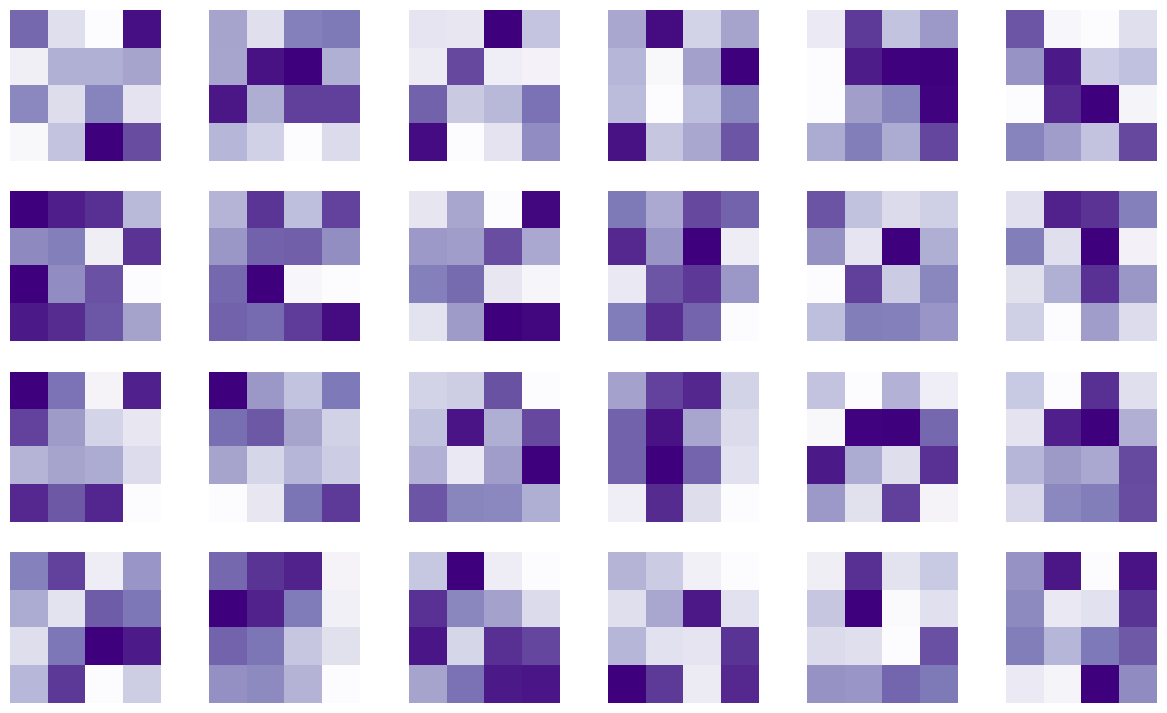

In [33]:
fig,axs = plt.subplots(4,6,figsize=(15,9))

for i in range(6*4):
  idx = np.unravel_index(i,(4,6))
  axs[idx].imshow( torch.squeeze(layer3W[idx[0], idx[1],:,:]).detach(), cmap='Purples')
  axs[idx].axis('off')